In [48]:

import os # miscellaneous operating system interfaces
import shutil # high-level file operations
import numpy as np
import cv2
import tensorflow as tf
import keras
import random
from itertools import product
from keras.models import Sequential,load_model
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications import MobileNetV2, Xception, DenseNet121,ResNet152V2,NASNetLarge,InceptionV3,InceptionResNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import  Input, Conv2D, Conv2DTranspose, ReLU,AveragePooling2D, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K



base_dir = "/content/drive/My Drive/Colab Notebooks/datasets/man"

train_img_dir = "/content/drive/My Drive/Colab Notebooks/datasets/man/train"

test_img_dir = "/content/drive/My Drive/Colab Notebooks/datasets/man/test"

val_img_dir = "/content/drive/My Drive/Colab Notebooks/datasets/man/val"


learning_rate = 0.001
training_epochs = 20 # traindata개수/batchsize
batch_size = 512
validation_steps = 20 # valdata개수/batchsize



print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

categories = ['dog','cat','bear','hamster','horse','wolf','dinosaur','racoon']

training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
                                             classes=categories, 
                                             batch_size=batch_size)

test_set = test_datagen.flow_from_directory(test_img_dir,
                                        target_size=(128,128), 
                                        classes=categories, 
                                        batch_size=batch_size)

val_set = test_datagen.flow_from_directory(val_img_dir,
                                        target_size=(128,128), 
                                        classes=categories, 
                                        batch_size=batch_size)

x_train, y_train = next(training_set)
x_test, y_test = next(test_set)
x_val,y_val = next(val_set)

batchSIZE is 512, Learning Rate is 0.001
Found 1120 images belonging to 8 classes.
Found 247 images belonging to 8 classes.
Found 211 images belonging to 8 classes.


In [49]:
def create_model():
    inputs = Input(shape=(128, 128, 3))
    

    conv2_1 = Conv2D(32, 3, 1, 'SAME')(inputs)
    conv2_2 = Conv2D(32, 3, 1, 'SAME')(conv2_1)
    pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_2)
    br1 = BatchNormalization()(pool2_3)
    
    conv2_1 = Conv2D(32, 3, 1, 'SAME')(br1)
    conv2_2 = Conv2D(32, 3, 1, 'SAME')(conv2_1)
    pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_2)
    br1 = BatchNormalization()(pool2_3)
    
    
    conv3_1 = Conv2D(64, 3, 1, 'SAME')(br1)
    conv3_2 = Conv2D(64, 3, 1, 'SAME')(conv3_1)
    pool3_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_2)
    br2 = BatchNormalization()(pool3_2)
    
    conv3_1 = Conv2D(64, 3, 1, 'SAME')(br2)
    conv3_2 = Conv2D(64, 3, 1, 'SAME')(conv3_1)
    pool3_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_2)
    br2 = BatchNormalization()(pool3_2)
    
    
    conv4_1 = Conv2D(128, 3, 1, 'SAME')(br2)
    conv4_2 = Conv2D(128, 3, 1, 'SAME')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_2)
    br3 = BatchNormalization()(pool4_2)
    
    conv4_1 = Conv2D(128, 3, 1, 'SAME')(br3)
    conv4_2 = Conv2D(128, 3, 1, 'SAME')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_2)
    br3 = BatchNormalization()(pool4_2)
    
    flatten1 = Flatten()(pool4_2)
    dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    dr1 = Dropout(0.7)(dense2)
    dense3 = Dense(units = 5, activation = 'sigmoid')(dr1)
    
    return keras.Model(inputs=inputs, outputs=dense3) 
def mobile_net():
    inputs = Input(shape=(128, 128, 3))
    mobileNet = MobileNetV2(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in mobileNet.layers:
        layer.trainable = True
        
    output = mobileNet.output
    pooling = AveragePooling2D(pool_size=(16,16),padding='SAME')(output)
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 256)(flatten1)
    batch1 = BatchNormalization()(dense1)
    relu1 = ReLU()(batch1)
    dense2 = Dense(units = 64)(relu1)
    batch2 = BatchNormalization()(dense2)
    relu2 = ReLU()(batch2)
    dense3 = Dense(units = 6, activation = 'sigmoid')(relu2)
    
    return keras.Model(inputs=inputs, outputs=dense3)

def xception():
    inputs = Input(shape=(128, 128, 3))
    xception = Xception(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in xception.layers:
        layer.trainable = True
        
    output = xception.output
    pooling = AveragePooling2D(pool_size=(8,8),padding='SAME')(output)
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 256)(flatten1)
    batch1 = BatchNormalization()(dense1)
    relu1 = ReLU()(batch1)
    dense2 = Dense(units = 64)(relu1)
    batch2 = BatchNormalization()(dense2)
    relu2 = ReLU()(batch2)
    dense3 = Dense(units = 8, activation = 'sigmoid')(relu2)
    
    return keras.Model(inputs=inputs, outputs=dense3)
    # pooling = AveragePooling2D(pool_size=(4,4),padding='SAME')(output)
    
    # flatten1 = Flatten()(pooling)
    # dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    # dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    # dr1 = Dropout(0.7)(dense2)
    # dense3 = Dense(units = 5, activation = 'sigmoid')(dr1)
    
    # return keras.Model(inputs=inputs, outputs=dense3)

def resnet():
    inputs = Input(shape=(128, 128, 3))
    resnet = ResNet152V2 (weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in resnet.layers:
        layer.trainable = True
        
    output = resnet.output
    pooling = MaxPooling2D(pool_size=(8,8),padding='SAME')(output)
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 128)(flatten1)
    batch1 = BatchNormalization()(dense1)
    relu1 = ReLU()(batch1)
    dense2 = Dense(units = 32)(relu1)
    batch2 = BatchNormalization()(dense2)
    relu2 = ReLU()(batch2)
    dense3 = Dense(units = 8, activation = 'sigmoid')(relu2)
    
    return keras.Model(inputs=inputs, outputs=dense3)

def densenet():
    inputs = Input(shape=(128, 128, 3))
    densenet = DenseNet121(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in densenet.layers:
        layer.trainable = True
        
    output = densenet.output
    pooling = MaxPooling2D(pool_size=(32,32),padding='SAME')(output)
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 112)(flatten1)
    batch1 = BatchNormalization()(dense1)
    relu1 = ReLU()(batch1)
    dense2 = Dense(units = 28)(relu1)
    batch2 = BatchNormalization()(dense2)
    relu2 = ReLU()(batch2)
    dense3 = Dense(units = 7, activation = 'softmax')(relu2)
    
    return keras.Model(inputs=inputs, outputs=dense3)


def inception():
    inputs = Input(shape=(128, 128, 3))
    inception = InceptionV3(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in inception.layers:
        layer.trainable = True
        
    output = inception.output
    pooling = MaxPooling2D(pool_size=(32,32),padding='SAME')(output)
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 1024)(flatten1)
    batch1 = BatchNormalization()(dense1)
    relu1 = ReLU()(batch1)
    dense2 = Dense(units = 512)(relu1)
    batch2 = BatchNormalization()(dense2)
    relu2 = ReLU()(batch2)
    dense3 = Dense(units = 8, activation = 'sigmoid')(relu2)
    
    return keras.Model(inputs=inputs, outputs=dense3)

def inceptionresnet():
    inputs = Input(shape=(128, 128, 3))
    inceptionresnet = InceptionResNetV2(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in inceptionresnet.layers:
        layer.trainable = True
        
    output = inceptionresnet.output
    pooling = MaxPooling2D(pool_size=(16,16),padding='SAME')(output)
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 1024)(flatten1)
    batch1 = BatchNormalization()(dense1)
    relu1 = ReLU()(batch1)
    dense2 = Dense(units = 512)(relu1)
    batch2 = BatchNormalization()(dense2)
    relu2 = ReLU()(batch2)
    dense3 = Dense(units = 8, activation = 'sigmoid')(relu2)
    
    return keras.Model(inputs=inputs, outputs=dense3)




class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h
    
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x
    
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(64, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # 14x14x16
        
        
        self.res2 = ResnetLayer(128, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
    
        
        self.res3 = ResnetLayer(256, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.res4 = ResnetLayer(512, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(5, activation='softmax')
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [50]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score



#model = create_model()
#model = ResNet()
#model = mobile_net()
#model = xception()
#model = densenet()
#model = resnet()
#model = inception()
model =inceptionresnet()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=training_epochs * 10,
                                                          decay_rate=0.5,
                                                          staircase=True)



# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96)

# optimizer는 Adam, loss는 sparse categorical crossentropy 사용
# label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics=['accuracy', precision, recall, f1score])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy', 
#     metrics=['accuracy', precision, recall, f1score],
# )




## Train!
history = model.fit(x_train, y_train, steps_per_epoch=training_epochs,
         epochs=120, validation_data = (x_val,y_val),validation_steps=validation_steps)
model.save('animal_model_man.h5')
# epochs = 30
# history = model.fit(
#     training_set, 
#     epochs=epochs,
#     steps_per_epoch=training_set.samples / epochs, 
#     validation_data=val_set,
#     validation_steps=val_set.samples / epochs,
# )

Epoch 1/120
20/20 [==============================] - 7s 352ms/step - loss: 0.4818 - accuracy: 0.3301 - precision: 0.4071 - recall: 0.3744 - f1score: 0.3321 - val_loss: 17.3587 - val_accuracy: 0.1327 - val_precision: 0.1144 - val_recall: 0.3432 - val_f1score: 0.1716
Epoch 2/120
20/20 [==============================] - 4s 203ms/step - loss: 0.1948 - accuracy: 0.6953 - precision: 0.7988 - recall: 0.5729 - f1score: 0.6605 - val_loss: 1.3729 - val_accuracy: 0.1185 - val_precision: 0.0977 - val_recall: 0.1955 - val_f1score: 0.1303
Epoch 3/120
20/20 [==============================] - 4s 205ms/step - loss: 0.1040 - accuracy: 0.8672 - precision: 0.8941 - recall: 0.8254 - f1score: 0.8576 - val_loss: 0.7918 - val_accuracy: 0.2512 - val_precision: 0.2900 - val_recall: 0.0955 - val_f1score: 0.1383
Epoch 4/120
20/20 [==============================] - 4s 205ms/step - loss: 0.0641 - accuracy: 0.9355 - precision: 0.9464 - recall: 0.9156 - f1score: 0.9300 - val_loss: 0.6727 - val_accuracy: 0.2607 - val_

247
index: 0  actual y: 6  answer y: 6  prediction: [ 0.04964209  0.02988461  0.04372352  0.05028407  0.01361464  0.04509573
 99.881676    0.2363162 ]
index: 1  actual y: 5  answer y: 3  prediction: [ 0.10734244  0.12737079  0.0768847  66.95565     0.25239044  7.136361
  9.226854    0.06078059]
index: 2  actual y: 3  answer y: 3  prediction: [ 0.04875905  0.0528871   0.01582567 99.91568     0.03541859  0.01896344
  0.00608019  0.10451549]
index: 3  actual y: 6  answer y: 6  prediction: [ 0.44959593  0.053372    0.04450177  0.1742409   0.02715758  0.16485396
 99.68181     0.05690145]
index: 4  actual y: 4  answer y: 4  prediction: [ 0.01047434  0.11930259  0.06597275  0.05002017 99.90375     0.02143622
  0.00833834  0.02310859]
index: 5  actual y: 0  answer y: 0  prediction: [98.48652     0.11230215  0.05276363  0.14501576  1.0908067   0.31781346
  0.08585168  0.17952764]
index: 6  actual y: 2  answer y: 2  prediction: [ 0.03127529  0.02492953 99.90824     0.01012786  0.01497389  0.0289

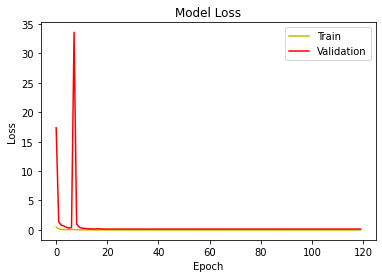

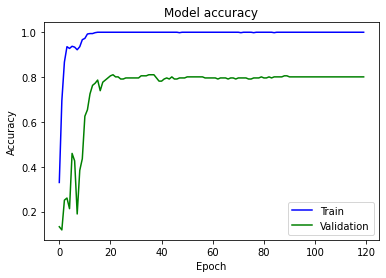

In [51]:
# output = classifier.predict_generator(test_set, steps=1)
# print(test_set.class_indices)
# print(output)
size = y_test[:,-1]
print(size.size)


# predict 10 random hand-writing data
y_predicted = model.predict(x_test)
for x in range(0,size.size):
    
   np.set_printoptions(suppress=True)
   print("index:", x,
          " actual y:", np.argmax(y_test[x]),
          " answer y:", np.argmax(y_predicted[x]),
          " prediction:", np.array(y_predicted[x] * 100))

_loss, _acc, _precision, _recall, _f1score = model.evaluate(x_test, y_test)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))
# print('loss: ', evaluation[0])
# print('accuracy', evaluation[1])

import matplotlib.pyplot as plt

# 손실 그래프
def plot_loss(history):
   # 선 그리기
    plt.plot(history.history['loss'], 'y', label='train loss')
    plt.plot(history.history['val_loss'], 'r', label='val loss')
   # 그래프 제목
    plt.title('Model Loss')
   # x,y축 이름 표시
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
   # 각 라인 표식 표시
    plt.legend(['Train','Validation'],loc=0)

# 정확도 그래프
def plot_acc(history):
  # dir(history.history)
    plt.plot(history.history['accuracy'], 'b', label='train accuracy')
    plt.plot(history.history['val_accuracy'], 'g', label='val accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

plot_loss(history)
plt.show()
plot_acc(history)
plt.show()